# Hadoop Mini Project Code Demo: Interacting with Hadoop using PySpark
### Jiechun Lin
### March 24, 2023  




-Google Cloud Dataproc is a managed Hadoop service that allows users to run Apache Hadoop clusters and Apache Spark in a simplified manner. When a Dataproc cluster reads files from a storage bucket, the data is processed through the HDFS layer of the cluster.

-PySpark is the Python API for Apache Spark, and it allows users to interact with Spark and perform data processing tasks using Python code.  

-When you launch a cluster on Google Cloud Dataproc, PySpark is already installed and configured on the cluster. Therefore, you do not need to install PySpark or configure the environment to use it. The environment is automatically set up and the necessary PySpark modules are imported for you. This includes the pyspark.sql module, which provides the SparkSession class for interacting with Spark SQL. Therefore, you can use the SparkSession class and other PySpark functionality without explicitly importing pyspark.sql.

-In this demo, we explored the 2022 NYC Yellow Taxi data from the official website of the NYC Taxi and Limousine Commission (https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). We analyzed the overall average tip rate, the average tip rate by passenger counts, the traffic load during congestion and non-congestion hours, and the corresponding average tip rate by passenger counts.

In [3]:
# Save all the 2022 NYC yellow taxi data files into a folder named "data" in my Google Cloud Storage bucket.
# Then, build a Spark object by using spark.read.parquet()

trips_df=spark.read.parquet("gs://liz-hadoop-bucket/data",header=True,inferSchema=True)

In [4]:
# Show the first 10 rows of the dataset
trips_df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2022-10-01 00:03:41|  2022-10-01 00:18:39|            1.0|          1.7|       1.0|                 N|         249|         107|           1|        9.5|  3.0|    0.5|      2.6

In [5]:
# Returns the number of rows in the DataFrame
trips_df.count()

39656098

In [6]:
# Number of features
len(trips_df.columns)

19

In [7]:
#  Prints the schema of a DataFrame in a tree format
# The NYC taxi Data dictionary is available on https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf 
trips_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [8]:
trips_df.dtypes

[('VendorID', 'bigint'),
 ('tpep_pickup_datetime', 'timestamp'),
 ('tpep_dropoff_datetime', 'timestamp'),
 ('passenger_count', 'double'),
 ('trip_distance', 'double'),
 ('RatecodeID', 'double'),
 ('store_and_fwd_flag', 'string'),
 ('PULocationID', 'bigint'),
 ('DOLocationID', 'bigint'),
 ('payment_type', 'bigint'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('mta_tax', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('improvement_surcharge', 'double'),
 ('total_amount', 'double'),
 ('congestion_surcharge', 'double'),
 ('airport_fee', 'double')]

In [9]:
# Find the unique values in each column of the DataFrame
for col in trips_df.columns:
    print(f"{col}: {trips_df.select(col).distinct().count()}")

VendorID: 4


tpep_pickup_datetime: 19878786


tpep_dropoff_datetime: 19868207


passenger_count: 11


trip_distance: 8701


RatecodeID: 8


store_and_fwd_flag: 3


PULocationID: 262


DOLocationID: 262


payment_type: 6


fare_amount: 13530


extra: 174


mta_tax: 45


tip_amount: 6790


tolls_amount: 2215


improvement_surcharge: 5


total_amount: 25692


congestion_surcharge: 11


airport_fee: 5


In [10]:
# There are null values in the dataset:
trips_df.select("RatecodeID").distinct().show()

+----------+
|RatecodeID|
+----------+
|      null|
|       1.0|
|       4.0|
|       3.0|
|       2.0|
|      99.0|
|       6.0|
|       5.0|
+----------+



In [11]:
trips_df.select("passenger_count").distinct().show()

+---------------+
|passenger_count|
+---------------+
|            8.0|
|            0.0|
|            7.0|
|           null|
|            1.0|
|            4.0|
|            3.0|
|            2.0|
|            6.0|
|            5.0|
|            9.0|
+---------------+



In [12]:
# We want to study the busiest operation time and the average tip rate.

from pyspark.sql.functions import col

# Selecting only the required columns
trips_df_sub = trips_df.select(
    col("tpep_pickup_datetime"), 
    col("tpep_dropoff_datetime"), 
    col("passenger_count"),
    col("fare_amount"), 
    col("tip_amount"),
    col("total_amount")
)

# Remove all rows with null values in the following columns
trips_df_sub= trips_df_sub.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'total_amount'])

# Filter out trips with 0 passengers(this happens when trips get cancelled)
trips_df_sub = trips_df_sub.filter(col("passenger_count") > 0)


In [13]:
trips_df_sub.count()

37524451

In [14]:
trips_df_sub.show(10)

+--------------------+---------------------+---------------+-----------+----------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|fare_amount|tip_amount|total_amount|
+--------------------+---------------------+---------------+-----------+----------+------------+
| 2022-10-01 00:03:41|  2022-10-01 00:18:39|            1.0|        9.5|      2.65|       15.95|
| 2022-10-01 00:14:30|  2022-10-01 00:19:48|            2.0|        5.5|       0.0|         9.3|
| 2022-10-01 00:27:13|  2022-10-01 00:37:41|            1.0|        9.0|      2.06|       12.36|
| 2022-10-01 00:22:52|  2022-10-01 00:52:14|            1.0|       25.5|       0.0|        29.3|
| 2022-10-01 00:33:19|  2022-10-01 00:44:51|            3.0|       10.5|       0.0|        14.3|
| 2022-10-01 00:02:42|  2022-10-01 00:50:01|            1.0|       41.0|       3.0|        47.8|
| 2022-10-01 00:06:35|  2022-10-01 00:24:38|            1.0|       23.5|      4.96|       31.01|
| 2022-10-01 00:29:25|  2022-1

In [15]:
# Let's calculate the average tip rate

from pyspark.sql.functions import mean,round

# Create a column called tip_rate
trips_df_sub=trips_df_sub.withColumn('tip_rate',round(col("tip_amount")/col("fare_amount"), 2))

# Calculate the average tip rate
avg_tip_rate = trips_df_sub.select(mean("tip_rate")).first()[0]

print("Average tip rate: {:.2%}".format(avg_tip_rate))

Average tip rate: 22.26%


In [16]:
trips_df_sub.show(10)

+--------------------+---------------------+---------------+-----------+----------+------------+--------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|fare_amount|tip_amount|total_amount|tip_rate|
+--------------------+---------------------+---------------+-----------+----------+------------+--------+
| 2022-10-01 00:03:41|  2022-10-01 00:18:39|            1.0|        9.5|      2.65|       15.95|    0.28|
| 2022-10-01 00:14:30|  2022-10-01 00:19:48|            2.0|        5.5|       0.0|         9.3|     0.0|
| 2022-10-01 00:27:13|  2022-10-01 00:37:41|            1.0|        9.0|      2.06|       12.36|    0.23|
| 2022-10-01 00:22:52|  2022-10-01 00:52:14|            1.0|       25.5|       0.0|        29.3|     0.0|
| 2022-10-01 00:33:19|  2022-10-01 00:44:51|            3.0|       10.5|       0.0|        14.3|     0.0|
| 2022-10-01 00:02:42|  2022-10-01 00:50:01|            1.0|       41.0|       3.0|        47.8|    0.07|
| 2022-10-01 00:06:35|  2022-10-01 00:24:38|  

In [17]:
# We're curious about the tip rate in terms of the number of passengers

avg_tip_rate_by_passenger_count = trips_df_sub.groupBy("passenger_count").agg(mean("tip_rate")).collect()

# Print the results
for row in avg_tip_rate_by_passenger_count:
    passenger_count = row[0]
    avg_tip_rate = row[1]
    print("Passenger count: {}, Average tip rate: {:.2%}".format(passenger_count, avg_tip_rate)) 

Passenger count: 8.0, Average tip rate: 13.89%
Passenger count: 7.0, Average tip rate: 11.29%
Passenger count: 1.0, Average tip rate: 22.58%
Passenger count: 4.0, Average tip rate: 18.24%
Passenger count: 3.0, Average tip rate: 20.24%
Passenger count: 2.0, Average tip rate: 20.91%
Passenger count: 6.0, Average tip rate: 21.01%
Passenger count: 5.0, Average tip rate: 30.13%
Passenger count: 9.0, Average tip rate: 10.38%


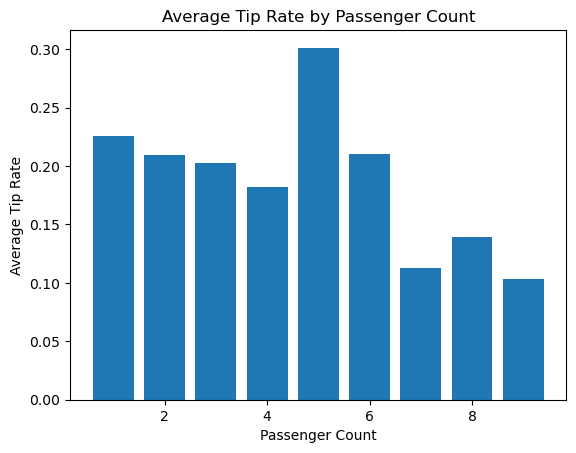

In [18]:
# Let's visualize the result 

import matplotlib.pyplot as plt

passenger_counts = [row[0] for row in avg_tip_rate_by_passenger_count]
avg_tip_rates = [row[1] for row in avg_tip_rate_by_passenger_count]
plt.bar(passenger_counts, avg_tip_rates)
plt.title("Average Tip Rate by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Average Tip Rate")
plt.show()

#You can see that the tip rate peaks at passenger count=5. 

In [19]:
# We're curious about the busiest taxi running hour 

from pyspark.sql.functions import hour

# Add a new column for pickup hour
trips_df_sub = trips_df_sub.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))

# Group by pickup hour and count number of trips
hourly_trip_counts = trips_df_sub.groupBy("pickup_hour").count().orderBy("pickup_hour")

# Print the results
print("Hourly trip counts:")
hourly_trip_counts.show(n=hourly_trip_counts.count(), truncate=False)


Hourly trip counts:


+-----------+-------+
|pickup_hour|count  |
+-----------+-------+
|0          |1037719|
|1          |682897 |
|2          |452348 |
|3          |296133 |
|4          |194552 |
|5          |227490 |
|6          |565522 |
|7          |1053132|
|8          |1408000|
|9          |1613729|
|10         |1797044|
|11         |1953153|
|12         |2106955|
|13         |2150524|
|14         |2299549|
|15         |2355620|
|16         |2336784|
|17         |2527852|
|18         |2650416|
|19         |2408636|
|20         |2088419|
|21         |2005138|
|22         |1834982|
|23         |1477857|
+-----------+-------+



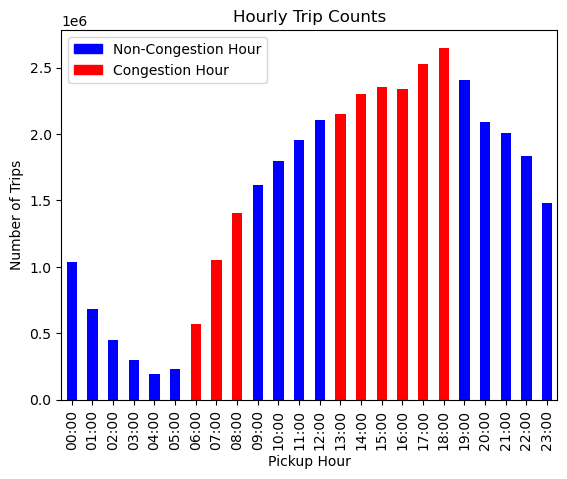

In [20]:
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
hourly_trip_counts_pd = hourly_trip_counts.toPandas()

# Plot the bar chart using Pandas
ax = hourly_trip_counts_pd.plot(kind='bar',x='pickup_hour', y='count', color='blue')

# Set the chart title and axis labels
ax.set_title('Hourly Trip Counts')
ax.set_xlabel('Pickup Hour')
ax.set_ylabel('Number of Trips')

# Set the x-axis tick labels to display the hour in 24-hour format
ax.set_xticklabels(hourly_trip_counts_pd['pickup_hour'].apply(lambda x: '{:02d}:00'.format(x)))


# New York City has set up congestion hours for taxis through
# a program called the "Congestion Surcharge" which was implemented in February 2019
congestion_hours = [6, 7, 8, 13, 14, 15, 16, 17, 18] 

# Highlight the congestion hours by setting their bars to red
for congestion_hour in congestion_hours:
    ax.patches[congestion_hour].set_fc('red')

# Create a custom legend for the plot
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='Non-Congestion Hour')
red_patch = mpatches.Patch(color='red', label='Congestion Hour')
plt.legend(handles=[blue_patch, red_patch])
       
# Show the plot
plt.show()


In [21]:
# Now we can look at the average trips during congestion hours and non-congestion hours

from pyspark.sql.functions import date_trunc


# Calculate the number of days of data
num_days = (trips_df_sub.select(date_trunc("day", col("tpep_pickup_datetime"))).distinct().count())

# Calculate the total number of trips during congestion hours
congestion_trips = hourly_trip_counts.filter(hourly_trip_counts["pickup_hour"].isin(congestion_hours)).agg({"count": "sum"}).collect()[0][0]

# Calculate the total number of trips during non-congestion hours
non_congestion_trips = hourly_trip_counts.filter(~hourly_trip_counts["pickup_hour"].isin(congestion_hours)).agg({"count": "sum"}).collect()[0][0]

# Calculate the average number of trips per hour during congestion hours
avg_congestion_trips = congestion_trips / (num_days * len(congestion_hours))

# Calculate the average number of trips per hour during non-congestion hours
avg_non_congestion_trips = non_congestion_trips / (num_days * (24 - len(congestion_hours)))

# Print the results
print("Average number of trips per hour during congestion hours: {:.2f}".format(avg_congestion_trips))
print("Average number of trips per hour during non-congestion hours: {:.2f}".format(avg_non_congestion_trips))

Average number of trips per hour during congestion hours: 5019.50
Average number of trips per hour during non-congestion hours: 3502.96


In [22]:
# We can look at the tip rate difference between the congest hours and non-congestion hours

from pyspark.sql.functions import when

# Create a new column to flag whether the trip occurred during congestion hours or not
trips_df_sub = trips_df_sub.withColumn("congestion_hour", when(col("pickup_hour").isin(congestion_hours), True).otherwise(False))

# Calculate the average tip rate by passenger count during congestion and non-congestion hours
avg_tip_rate_by_ch= trips_df_sub.groupBy("congestion_hour", "passenger_count").agg(mean("tip_rate").alias("avg_tip_rate"))


avg_tip_rate_by_ch.show()


+---------------+---------------+-------------------+
|congestion_hour|passenger_count|       avg_tip_rate|
+---------------+---------------+-------------------+
|          false|            9.0|0.09705882352941175|
|           true|            6.0|0.20753550437302273|
|           true|            7.0|0.11855769230769232|
|          false|            2.0|0.21765218945278964|
|           true|            3.0|0.18969972876550872|
|           true|            9.0|0.10741935483870968|
|           true|            5.0|0.21441545395668607|
|           true|            8.0|0.12488636363636364|
|          false|            3.0| 0.2131855967661771|
|          false|            7.0|0.10791666666666667|
|          false|            8.0|0.16250000000000003|
|          false|            4.0|0.18595409217618894|
|           true|            2.0|0.19847578701723279|
|          false|            5.0|0.36984537641585724|
|           true|            1.0|0.22174855412209227|
|           true|           

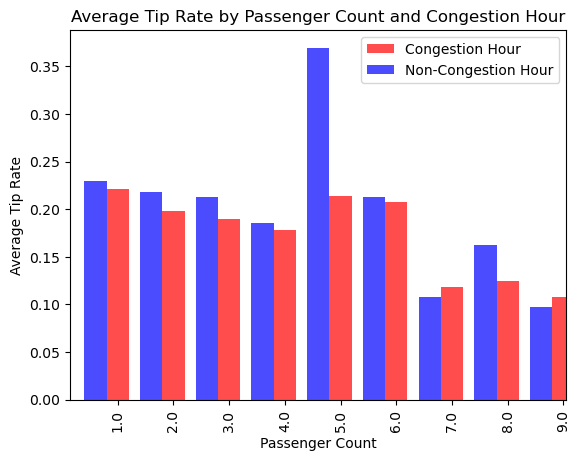

In [23]:
# Visualize the above output

# Convert the PySpark DataFrame to a Pandas DataFrame
avg_tip_rate_by_ch_pd = avg_tip_rate_by_ch.toPandas()

# Sort the DataFrame by passenger_count in ascending order
avg_tip_rate_by_ch_pd = avg_tip_rate_by_ch_pd.sort_values("passenger_count")

# Create two DataFrames for congestion and non-congestion hours
congestion_hour_df = avg_tip_rate_by_ch_pd[avg_tip_rate_by_ch_pd["congestion_hour"] == True]
non_congestion_hour_df = avg_tip_rate_by_ch_pd[avg_tip_rate_by_ch_pd["congestion_hour"] == False]

# Set the width of the bars
bar_width = 0.4

# Plot the bar chart using Pandas
fig, ax = plt.subplots()
congestion_hour_df.plot(kind="bar", x="passenger_count", y="avg_tip_rate", color="red", alpha=0.7, position=0.5, width=bar_width, ax=ax)
non_congestion_hour_df.plot(kind="bar", x="passenger_count", y="avg_tip_rate", color="blue", alpha=0.7, position=1.5, width=bar_width, ax=ax)

# Set the chart title and axis labels
ax.set_title('Average Tip Rate by Passenger Count and Congestion Hour')
ax.set_xlabel('Passenger Count')
ax.set_ylabel('Average Tip Rate')

ax.legend(["Congestion Hour", "Non-Congestion Hour"])

plt.show()

# Interestingly, we don't see significant difference in tip rate between congestion hour and non-congestion hour, except
# for when the passenger count is 5, where the tip rate is higher during non-congestion hours.

In [24]:
# Take a look of the data we processed
trips_df_sub.show()

+--------------------+---------------------+---------------+-----------+----------+------------+--------+-----------+---------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|fare_amount|tip_amount|total_amount|tip_rate|pickup_hour|congestion_hour|
+--------------------+---------------------+---------------+-----------+----------+------------+--------+-----------+---------------+
| 2022-10-01 00:03:41|  2022-10-01 00:18:39|            1.0|        9.5|      2.65|       15.95|    0.28|          0|          false|
| 2022-10-01 00:14:30|  2022-10-01 00:19:48|            2.0|        5.5|       0.0|         9.3|     0.0|          0|          false|
| 2022-10-01 00:27:13|  2022-10-01 00:37:41|            1.0|        9.0|      2.06|       12.36|    0.23|          0|          false|
| 2022-10-01 00:22:52|  2022-10-01 00:52:14|            1.0|       25.5|       0.0|        29.3|     0.0|          0|          false|
| 2022-10-01 00:33:19|  2022-10-01 00:44:51|            3.0|  

In [26]:
# We can save the above processed data into the format we want
trips_df_sub.write.save("gs://liz-hadoop-bucket/dataout/nycyellowtaxi2022.csv",format="csv",header=True)